# GA Analytics
## Feature Engineering, Pre-processing, and Modelling
### Blaine Murphy -- September 2021


For the feature engineering phase I will do the following.
- Read in the data exported from the EDA notebook
- Encode categorical features identified in EDA
- Condense data to user level
    - to help answer the business question for identifying big spenders and how to market to them
    - compute the target -- ln(total_user_revenue+1)
    - Calculate user level features with summary statistics for numeric features
- Split data into train, validation, and test for modelling
- Scale the data based on the training data
- Export data sets prepped for modelling

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')
os.listdir()

['e390021b-3cdc-4df0-b92e-22082e3ad15b_Data.csv',
 'GA_features.csv',
 'GA_Test.npz',
 'GA_Train.npz',
 'GA_Validation.npz',
 'GDP by Country world bank.csv',
 'life expectency by country_world bank.csv',
 'Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Country_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'Metadata_Indicator_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Indicator_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'model.png',
 'Population by country world bank.csv',
 'sample_submission.csv',
 'sample_submission_v2.csv',
 'test.csv',
 'test_v2.csv',
 'train.csv',
 'train_eda.csv',
 'train_v2.csv',
 'train_wrangled.csv',
 'user_train_X.csv',
 'user_train_y.csv',
 'worldpopulationreview.com']

In [3]:
train = pd.read_csv('train_eda.csv',index_col=0,parse_dates=['date','dateTime'])
train.info()

C:\Users\blain\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 50 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

A couple of columns to fix. `keyword` is mostly null and I already created new columns from it based on the most frequent search words that resulted in a purchase.  I can drop it now.  

And `timeDiffLastVisit` is mostly null because most of the records are new visits, not repeat visits.  I will fill all of those nulls with the maximum of the `timeDiffLastVisit` column.


In [4]:
train.drop('keyword',axis=1,inplace=True)
train['timeDiffLastVisit'] = train.timeDiffLastVisit.fillna(train.timeDiffLastVisit.max())


In [5]:
### Convert to float for summary statistics below
train['hits'] = train['hits'].astype('float')
train['pageviews'] = train['pageviews'].astype('float')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 49 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

In [7]:
window_start = train['visitStartTime'].min()
window_end = train['visitStartTime'].max()

### One hot encoding of categorical columns

In [8]:
"','".join(list(train.columns))

"channelGrouping','date','fullVisitorId','sessionId','visitId','visitNumber','visitStartTime','browser','operatingSystem','isMobile','deviceCategory','continent','subContinent','country','region','metro','city','campaign','source','hits','pageviews','bounces','newVisits','transactionRevenue','dollars','purchase','dateTime','hour','weekend','month','time','timeDiffLastVisit','countryPopulation','countryGDP','countryLE','state','keywordStore','keywordMerch','keywordShirt','keywordGoogle','keywordYoutube','keywordShop','keywordApparel','keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)','keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search"

In [9]:
num_cols = ['fullVisitorId','visitNumber','isMobile','hits','pageviews','bounces','newVisits',\
        'visitStartTime','weekend','time','timeDiffLastVisit',\
        'countryPopulation','countryGDP','countryLE','keywordStore',\
        'keywordMerch','keywordShirt','keywordGoogle',\
        'keywordYoutube','keywordShop','keywordApparel',\
        'keyword_(Remarketing/Content targeting)',\
        'keyword_(User vertical targeting)','keyword_(automatic matching)',\
        'keyword_(content targeting)','keyword_(not provided)','keyword_search',\
        'dollars','transactionRevenue']

In [10]:
dummy_cols = ['channelGrouping','browser','operatingSystem',\
              'deviceCategory','subContinent','city','state',\
              'campaign','source','month','hour']

In [11]:
### convert month to object for label encoding, ditto for hour
train['month'] = train['month'].astype('object')
train['month'].dtype

train['hour'] = train['hour'].astype('object')


In [12]:
train = pd.concat([train[num_cols],pd.get_dummies(train[dummy_cols])], axis=1)

In [13]:
train.shape

(901907, 343)

In [14]:
train_cols = list(train.columns)

### Grouping by user

In [15]:
bool_cols = ['isMobile','weekend','bounces','keywordStore','keywordMerch','keywordShirt',\
             'keywordGoogle','keywordYoutube','keywordShop','keywordApparel',\
             'keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)',\
             'keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search' ]

In [16]:
user_groupby = train.groupby('fullVisitorId', as_index=True)

Creation of target in a new user level dataframe

In [17]:
### Function for creation of target column ln(total_revenue_per_user + 1)
TargetFunc = lambda x: np.log(sum(x) + 1.0)

### Calculate target
X = user_groupby[['transactionRevenue']].agg(TargetFunc)


In [18]:
### Create features based on visits
X['visits'] = user_groupby[['transactionRevenue']].count()
X['visitMax'] = user_groupby['visitNumber'].max()
X['visitMin'] = user_groupby['visitNumber'].min()

### Create features based on time between visits and start and end of the data window
X['timeTilFirstVisit'] = user_groupby['visitStartTime'].agg(lambda x: min(x) - window_start)
X['timeLastVisitFromEnd'] = user_groupby['visitStartTime'].agg(lambda x: window_end - max(x))



### Create statistical measures of numerical columns
for col in ['hits','pageviews','timeDiffLastVisit']:
    dum = user_groupby[[col]].agg(['min','max','median','mean','std'])
    dum.columns = [col+i.capitalize() for i in ['min','max','median','mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum

    
for col in ['countryPopulation','countryGDP','countryLE']:
    dum = user_groupby[[col]].agg(['mean','std'])
    dum.columns = [col+i.capitalize() for i in ['mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum
    
### calculate mean of boolean columns
for col in bool_cols:
    dum = user_groupby[[col]].mean()
    dum.columns = [col+'Mean']
    X = pd.concat([X,dum], axis=1)
    del dum

### Mean of dummy columns with correct column naming
for col in dummy_cols:
    for dumi_col in [i for i in train_cols if i.startswith(col)]:
        dum = user_groupby[[dumi_col]].mean()
        dum.columns = [dumi_col+'Mean']
        X = pd.concat([X,dum], axis=1)
        del dum



    
X.head()

,transactionRevenue,visits,visitMax,visitMin,timeTilFirstVisit,timeLastVisitFromEnd,hitsMin,hitsMax,hitsMedian,hitsMean,...,hour_14Mean,hour_15Mean,hour_16Mean,hour_17Mean,hour_18Mean,hour_19Mean,hour_20Mean,hour_21Mean,hour_22Mean,hour_23Mean
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
4823595352351,0.0,1,1,1,7976698,23645683,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5103959234087,0.0,1,1,1,1782396,29839985,10.0,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10278554503158,0.0,1,1,1,6994654,24627727,11.0,11.0,11.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20424342248747,0.0,1,1,1,10544089,21078292,17.0,17.0,17.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26722803385797,0.0,1,1,1,26623582,4998799,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_cols = X.columns

In [20]:
nulls = X.isna().sum().T
nulls[nulls>0]

hitsStd                 631804
pageviewsStd            631804
timeDiffLastVisitStd    631804
countryPopulationStd    631804
countryGDPStd           631804
countryLEStd            631804
dtype: int64

In [21]:
X = X.fillna(0)

In [22]:
del train

In [23]:
y = X.pop('transactionRevenue')

In [24]:
X.shape

(722668, 356)

In [25]:
random_seed = 33

In [26]:
### Split into 70-20-10 train-validation-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.333, random_state=random_seed)


In [27]:
print('Train features:', X_train.shape)
print('Train target:', y_train.shape)
print('Validation features:',X_val.shape)
print('Validation target:',y_val.shape)
print('Test features:',X_test.shape)
print('Test target:',y_test.shape)


Train features: (505867, 356)
Train target: (505867,)
Validation features: (144606, 356)
Validation target: (144606,)
Test features: (72195, 356)
Test target: (72195,)


In [28]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train, X_test, X_val = ss.transform(X_train), ss.transform(X_test), ss.transform(X_val)




In [29]:
np.savez('GA_Train', inputs=X_train, targets = y_train)
np.savez('GA_Validation', inputs=X_val, targets = y_val)
np.savez('GA_Test', inputs=X_test, targets = y_test)

In [31]:
with open('GA_features.csv','w') as f:
    [f.write(col+'\n') for col in X_cols]

    

Data saved.

In [32]:
print('Train Frac of purchasers:', np.sum(y_train > 1) / y_train.shape[0])
print('Validation Frac purchasers:', np.sum(y_val > 1) / y_val.shape[0])
print('Test Frac purchasers:', np.sum(y_test > 1) / y_test.shape[0])

Train Frac of purchasers: 0.014132173081066762
Validation Frac purchasers: 0.013747700648659116
Test Frac purchasers: 0.013865226123692776


## Modelling phase

### Linear Regression with Lasso to get a baseline model performance and quick look at feature importance

In [1]:
import pandas as pd
import numpy as np
import os 

os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')

In [2]:
### Loading data
train = np.load('GA_Train.npz')
valid = np.load('GA_Validation.npz')
test = np.load('GA_Test.npz')


In [3]:
from sklearn.linear_model import Lasso
lass = Lasso()
lass.fit(train['inputs'], train['targets'])

Lasso()

In [4]:
from sklearn.metrics import mean_squared_error
print('Lasso Regression RMSE:\n{:.3f}'.format(np.sqrt(mean_squared_error(valid['targets'],lass.predict(valid['inputs'])))))


Lasso Regression RMSE:
2.078


In [5]:
print(lass.coef_)

[ 0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0. -0.  0.
  0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0.  0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0.  0. -0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0. -0.
  0.  0.  0. -0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.
  0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.
  0.  0. -0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0. -0. -0.
  0. -0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.
  0. -0. -0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.
  0.  0.  0. -0. -0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0. -0.  0.  0.
  0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0. -0

Due to the large number of users who didn't make a purchaes The model predicts nobody will make a purchase.  

### Moving on to deep learning with TensorFlow

In [6]:
import tensorflow as tf


In [7]:
train_num_purchasers = np.sum(train['targets'] > 1) 

#train['targets'].shape[0] / train_num_purchasers

print('There should be a purchase every {:.0f} records'.format(train['targets'].shape[0] / train_num_purchasers))


There should be a purchase every 71 records


In the training set I would expect to see one purchase every 71 records. I will try a batch size of 500 to try to get multiple purchases in each batch

In [8]:
### Declare some variables for modelling 

input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


Model building

In [9]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 3s - loss: 3.0809 - root_mean_squared_error: 1.7553 - mean_absolute_error: 0.4158 - val_loss: 2.7421 - val_root_mean_squared_error: 1.6559 - val_mean_absolute_error: 0.3523
Epoch 2/50
1012/1012 - 2s - loss: 2.7672 - root_mean_squared_error: 1.6635 - mean_absolute_error: 0.3482 - val_loss: 2.6386 - val_root_mean_squared_error: 1.6244 - val_mean_absolute_error: 0.2823
Epoch 3/50
1012/1012 - 3s - loss: 2.6993 - root_mean_squared_error: 1.6430 - mean_absolute_error: 0.3313 - val_loss: 2.5638 - val_root_mean_squared_error: 1.6012 - val_mean_absolute_error: 0.3203
Epoch 4/50
1012/1012 - 3s - loss: 2.6415 - root_mean_squared_error: 1.6253 - mean_absolute_error: 0.3245 - val_loss: 2.7195 - val_root_mean_squared_error: 1.6491 - val_mean_absolute_error: 0.3210
Epoch 5/50
1012/1012 - 2s - loss: 2.5955 - root_mean_squared_error: 1.6110 - mean_absolute_error: 0.3170 - val_loss: 2.5590 - val_root_mean_squared_error: 1.5997 - val_mean_absolute_error: 0.2899
Epoch 6/50
1012/1012

In [11]:
import matplotlib.pyplot as plt
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    

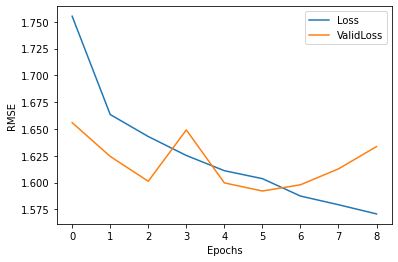

In [12]:
PlotLoss(history)

In [13]:
model.metrics_names

['loss', 'root_mean_squared_error', 'mean_absolute_error']

In [14]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
base_seq_nn = pd.DataFrame(perf,index = ['train','validation','test'])
base_seq_nn

2257/2257 [==============================] - 2s 681us/step - loss: 2.6245 - root_mean_squared_error: 1.6200 - mean_absolute_error: 0.3023


,RMSE
train,1.555521
validation,1.592071
test,1.620039


The test RMSE is higher than the validation RMSE suggesting that this model is overfitting to the train and validation sets.  Now visualizing the model predictions.

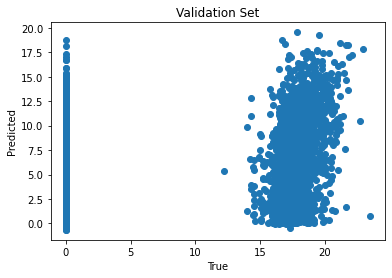

In [15]:
plt.scatter(valid['targets'],model.predict(valid['inputs']))
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation Set')
plt.show()

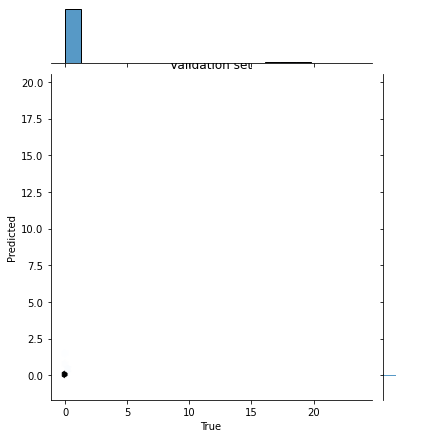

In [16]:
import seaborn as sns
sns.jointplot(x=valid['targets'],y=model.predict(valid['inputs']).reshape(-1), kind='hex')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation set')
plt.show()

It is hard to see the model predictions due to the very large numbers of ~0-0 true-predictions.  I will null these out and see if what the predictions look like.

In [17]:
mask = (valid['targets']<1.0) & (model.predict(valid['inputs']).reshape(-1)<1.0)
print(sum(mask))

138863


In [18]:
valid_target_masked = np.copy(valid['targets'])
valid_target_masked[mask==True] = np.NAN

valid_predicted_masked = np.copy(model.predict(valid['inputs']).reshape(-1))
valid_predicted_masked[mask==True] = np.NAN

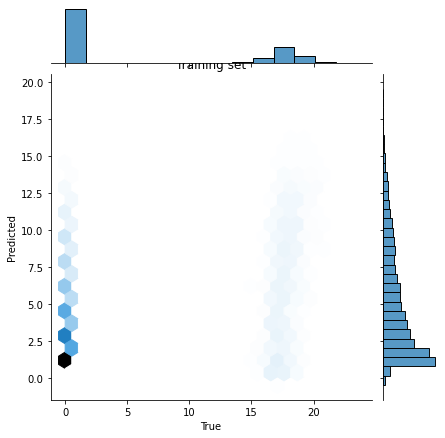

In [19]:
import seaborn as sns
sns.jointplot(x=valid_target_masked , y=valid_predicted_masked, dropna=True, kind='hex')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training set')
plt.show()

Not great. The 3 layer NN does not do a great job of predicting user revenue.  As shown before, only about 1% of the users made a purchase, and I believe this imbalance could be what's causing the poor results.  
___
## NN Classifier for purchase
Now I will try to create a NN model that predicts only whether a purchase was made. If that is succesful it could be an input into the regression model.  



In [20]:
train_purchase = 1.0 * np.array( [train['targets'] == 0, train['targets']>0] ).T
valid_purchase = 1.0 * np.array( [valid['targets'] ==0 , valid['targets'] > 0] ).T
test_purchase = 1.0 * np.array( [test['targets'] ==0 , test['targets'] > 0] ).T

In [21]:
### 
input_size = train['inputs'].shape[1]
output_size = 2
hidden_layer_size = 64
batch_size = 500
epochs = 50

In [22]:
clf_model = tf.keras.Sequential()
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dropout(.2))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dense(output_size,activation='softmax'))

clf_model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])




In [23]:
stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = clf_model.fit(train['inputs'],train_purchase,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        callbacks=stop,                    
                        validation_data=(valid['inputs'],valid_purchase),
                        verbose=2
                       )                    

Epoch 1/50
1012/1012 - 6s - loss: 0.0406 - auc: 0.9974 - precision: 0.9864 - recall: 0.9864 - val_loss: 0.0284 - val_auc: 0.9985 - val_precision: 0.9884 - val_recall: 0.9884
Epoch 2/50
1012/1012 - 3s - loss: 0.0294 - auc: 0.9983 - precision: 0.9877 - recall: 0.9877 - val_loss: 0.0280 - val_auc: 0.9986 - val_precision: 0.9887 - val_recall: 0.9887
Epoch 3/50
1012/1012 - 3s - loss: 0.0281 - auc: 0.9985 - precision: 0.9879 - recall: 0.9879 - val_loss: 0.0274 - val_auc: 0.9986 - val_precision: 0.9884 - val_recall: 0.9884
Epoch 4/50
1012/1012 - 4s - loss: 0.0272 - auc: 0.9986 - precision: 0.9882 - recall: 0.9882 - val_loss: 0.0274 - val_auc: 0.9984 - val_precision: 0.9887 - val_recall: 0.9887
Epoch 5/50
1012/1012 - 4s - loss: 0.0267 - auc: 0.9987 - precision: 0.9884 - recall: 0.9884 - val_loss: 0.0270 - val_auc: 0.9988 - val_precision: 0.9889 - val_recall: 0.9889
Epoch 6/50
1012/1012 - 3s - loss: 0.0261 - auc: 0.9987 - precision: 0.9885 - recall: 0.9885 - val_loss: 0.0274 - val_auc: 0.9983 -

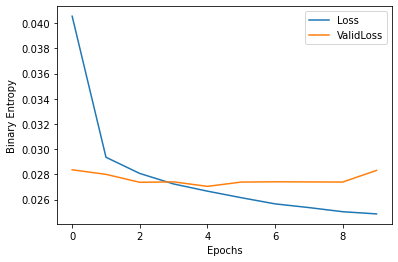

In [24]:
def PlotClfLoss(hist):
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Entropy')
    plt.legend()
    plt.show()
    
PlotClfLoss(history)

In [25]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix
train_predict_proba = clf_model.predict(train['inputs'])[:,1]
valid_predict_proba = clf_model.predict(valid['inputs'])[:,1]
test_predict_proba = clf_model.predict(test['inputs'])[:,1]

train_predicts = 1 * (train_predict_proba > 0.1)
valid_predicts = 1 * (valid_predict_proba > 0.1)

print('Train ROC AUC:', roc_auc_score(train_predicts ,train_predict_proba ))
print('Train Recall:',recall_score(train_purchase[:,1], train_predicts))
print('Train Precision:',precision_score(train_purchase[:,1], train_predicts))
print()
print('Validation ROC AUC:', roc_auc_score(valid_purchase[:,1], valid_predict_proba ))
print('Validation Recall:',recall_score(valid_purchase[:,1], valid_predicts))
print('Validation Precision:',precision_score(valid_purchase[:,1], valid_predicts))

Train ROC AUC: 1.0
Train Recall: 0.78024898587215
Train Precision: 0.48260944800138433

Validation ROC AUC: 0.9889902245655
Validation Recall: 0.7474849094567404
Validation Precision: 0.45291069795793965


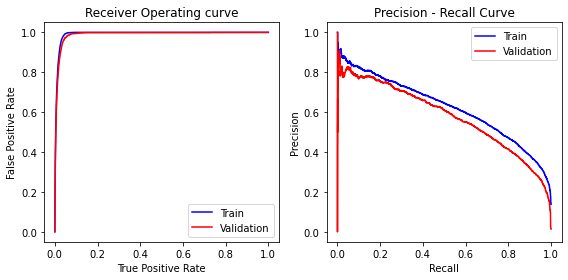

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve
fig,ax = plt.subplots(1,2, figsize = (8,4), tight_layout=True)

tpr, fpr, thresh = roc_curve(train_purchase[:,1], train_predict_proba)
ax[0].plot(tpr,fpr,c='blue')

tpr, fpr, thresh = roc_curve(valid_purchase[:,1], valid_predict_proba)
ax[0].plot(tpr,fpr,c='red')

ax[0].set_title('Receiver Operating curve')
ax[0].set_xlabel('True Positive Rate')
ax[0].set_ylabel('False Positive Rate')
ax[0].legend(labels=['Train','Validation'],loc='lower right')

p,r,t = precision_recall_curve(train_purchase[:,1], train_predict_proba)
ax[1].plot(r,p,c='blue')
p,r,t = precision_recall_curve(valid_purchase[:,1], valid_predict_proba)
ax[1].plot(r,p,c='red')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision - Recall Curve')
ax[1].legend(labels=['Train','Validation'])
plt.show()



These features are pretty good at predicting if there was a purchase, but I didn't take the final pre-processing steps that I normally would for a classification problem (multicollinearity).  Quick check on the test set.

In [27]:
print('Test ROC AUC:', roc_auc_score(test_purchase[:,1], test_predict_proba ))

Test ROC AUC: 0.9881152642340383


The classifier looks useful.  Now I will append the classification probability to the model and re-do the regression.

## Using classifier prediction in regression model
Now how to use the predicted purchase in a regression model.  Is there a way to combine the classification and regression models into one? A model inside a model? For now I will concatenate the classification predicted probabilities to the inputs of the data sets, an create a new regression NN.

In [28]:
train['inputs'].shape

(505867, 356)

In [29]:
X_train = np.hstack([train['inputs'],train_predict_proba.reshape(-1,1)])

X_valid = np.hstack([valid['inputs'],valid_predict_proba.reshape(-1,1)])

X_test = np.hstack([test['inputs'],test_predict_proba.reshape(-1,1)])
print(X_train.shape)

(505867, 357)


Now going back to a tf regression modelling

In [30]:
input_size = X_train.shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50


In [31]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))




model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=X_train,
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid,valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 4s - loss: 3.0265 - root_mean_squared_error: 1.7397 - mean_absolute_error: 0.4102 - val_loss: 2.5967 - val_root_mean_squared_error: 1.6114 - val_mean_absolute_error: 0.3208
Epoch 2/50
1012/1012 - 3s - loss: 2.6719 - root_mean_squared_error: 1.6346 - mean_absolute_error: 0.3381 - val_loss: 2.5431 - val_root_mean_squared_error: 1.5947 - val_mean_absolute_error: 0.3273
Epoch 3/50
1012/1012 - 3s - loss: 2.5956 - root_mean_squared_error: 1.6111 - mean_absolute_error: 0.3222 - val_loss: 2.6219 - val_root_mean_squared_error: 1.6192 - val_mean_absolute_error: 0.3111
Epoch 4/50
1012/1012 - 2s - loss: 2.5449 - root_mean_squared_error: 1.5953 - mean_absolute_error: 0.3123 - val_loss: 2.5472 - val_root_mean_squared_error: 1.5960 - val_mean_absolute_error: 0.2995
Epoch 5/50
1012/1012 - 2s - loss: 2.5186 - root_mean_squared_error: 1.5870 - mean_absolute_error: 0.3092 - val_loss: 2.6087 - val_root_mean_squared_error: 1.6151 - val_mean_absolute_error: 0.3058
Epoch 6/50
1012/1012

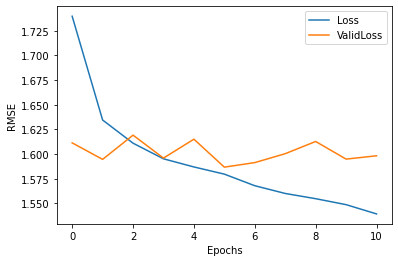

In [33]:
def PlotLoss(hist):
    plt.plot(np.sqrt(hist.history['loss']), label='Loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
PlotLoss(history)

In [35]:
perf = {'RMSE':[]}
for inputs, r_targets in zip([X_train,X_valid, X_test],
                                             [train['targets'],valid['targets'], test['targets']]):
    
    dum = model.evaluate(inputs,r_targets)
    perf['RMSE'].append(dum[1])
    
    del dum
seq_nn_w_clf = pd.DataFrame(perf,index = ['train','validation','test'])
seq_nn_w_clf

2257/2257 [==============================] - 1s 597us/step - loss: 2.6230 - root_mean_squared_error: 1.6196 - mean_absolute_error: 0.2943


,RMSE
train,1.539805
validation,1.586827
test,1.619583


In [36]:
base_seq_nn

,RMSE
train,1.555521
validation,1.592071
test,1.620039


There was only a very small improvement in using the classifier prediction for the regression model for the validation and test sets.  The training set has decreased more, but it looks to be overfitting to the training set, not really an improvement.

### Expected revenue
Next I'll try multiplying the regression prediction by the classification probability, a sort of expected purchase for each user. There is a Multiply layer so maybe I can pass the classifier probabilities to the regression model.  For now I will simply take the classifier probabilities multiplied by the regression output.

In [37]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 50

In [38]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))





model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
1012/1012 - 2s - loss: 3.0730 - root_mean_squared_error: 1.7530 - mean_absolute_error: 0.4154 - val_loss: 2.6780 - val_root_mean_squared_error: 1.6365 - val_mean_absolute_error: 0.3186
Epoch 2/50
1012/1012 - 2s - loss: 2.7652 - root_mean_squared_error: 1.6629 - mean_absolute_error: 0.3480 - val_loss: 2.5640 - val_root_mean_squared_error: 1.6013 - val_mean_absolute_error: 0.3253
Epoch 3/50
1012/1012 - 2s - loss: 2.6822 - root_mean_squared_error: 1.6377 - mean_absolute_error: 0.3344 - val_loss: 2.5703 - val_root_mean_squared_error: 1.6032 - val_mean_absolute_error: 0.3184
Epoch 4/50
1012/1012 - 2s - loss: 2.6541 - root_mean_squared_error: 1.6291 - mean_absolute_error: 0.3280 - val_loss: 2.5270 - val_root_mean_squared_error: 1.5897 - val_mean_absolute_error: 0.3087
Epoch 5/50
1012/1012 - 3s - loss: 2.6097 - root_mean_squared_error: 1.6155 - mean_absolute_error: 0.3163 - val_loss: 2.5745 - val_root_mean_squared_error: 1.6045 - val_mean_absolute_error: 0.3016
Epoch 6/50
1012/1012

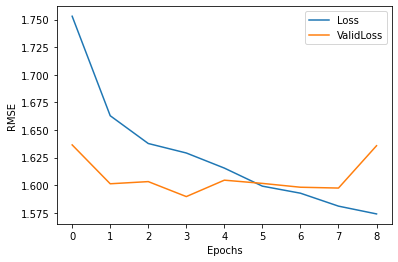

In [40]:
PlotLoss(history)

In [41]:
train_predict_exp = model.predict(train['inputs']) * train_predict_proba.reshape(1,-1).T

valid_predict_exp = model.predict(valid['inputs']) * valid_predict_proba.reshape(1,-1).T

test_predict_exp = model.predict(test['inputs']) * test_predict_proba.reshape(1,-1).T

In [42]:
print('Train RMSE:',np.sqrt(mean_squared_error(train['targets'],train_predict_exp)))
print('Validation RMSE:',np.sqrt(mean_squared_error(valid['targets'],valid_predict_exp)))
print('Test RMSE:',np.sqrt(mean_squared_error(test['targets'],test_predict_exp)))

Train RMSE: 1.7048629627913703
Validation RMSE: 1.7033697604478688
Test RMSE: 1.7400272747389773


These numbers are worse, and of course they are the model is solved for by minimizing the MSE and then I multiplied the output by some scalar it hasn't seen before.  I need to figure out how to add the multiplication of the purchase probability as the last layer in the tf model.

### Now using Keras' Functional API I will attempt a network of layers to create a regressor and classifier in 1 model
I will do this 2 ways:
- the classifier as a probability multiplied by the regression output
- the classifier as an input into the regression

The model will use the same inputs, and have two ouputs, a classifier for a purchase and a regressor for the size of the purchase. The model will optimize for both at the same time.

In [43]:
#import tensorflow as tf
#import pandas as pd
#import matplotlib.pyplot as plt

In [45]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 500
epochs = 100

In [46]:
### Creation of classifier targets (already have regrssion targets)
train_purchase = 1.0 * np.array( [train['targets'] == 0, train['targets']>0] ).T
valid_purchase = 1.0 * np.array( [valid['targets'] ==0 , valid['targets'] > 0] ).T
test_purchase = 1.0 * np.array( [test['targets'] ==0 , test['targets'] > 0] ).T

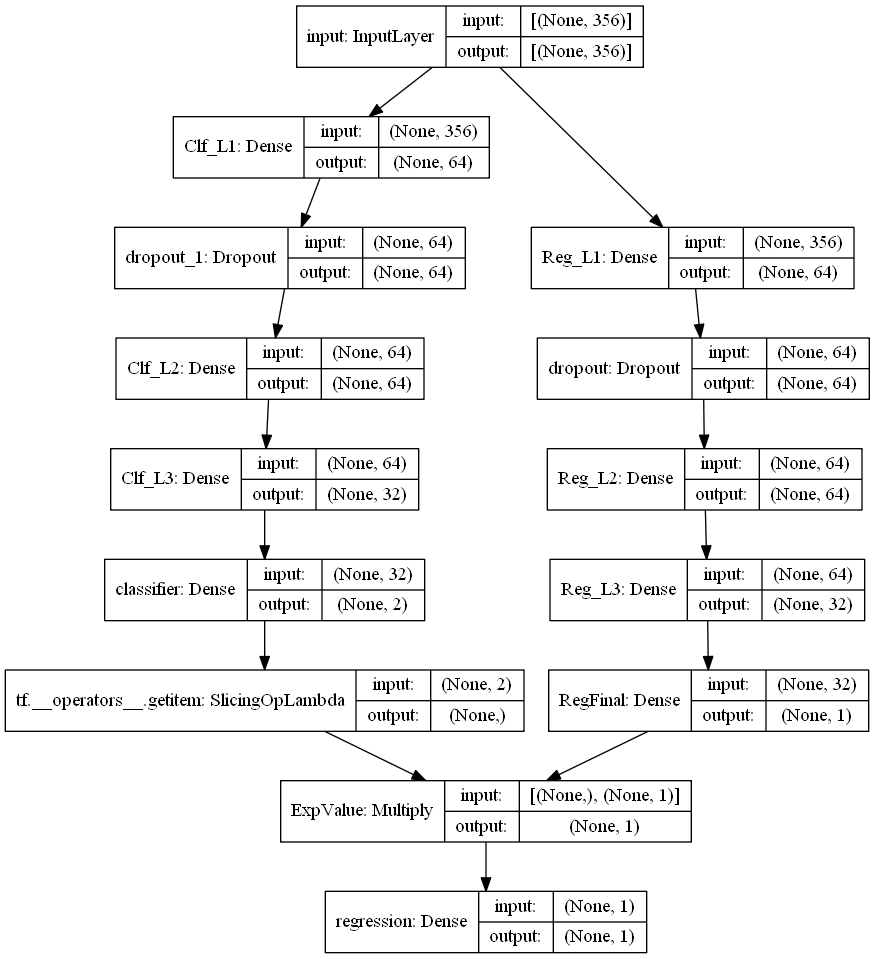

In [47]:
tf.keras.backend.clear_session()
### Create input layer
inputs = tf.keras.Input(shape=(input_size,),name='input') # shape (features,)

### Now build regression portion of model
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L1')(inputs) # shape (None, 64)
reg = tf.keras.layers.Dropout(.2)(reg)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L2')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(hidden_layer_size//2, activation='relu', name='Reg_L3')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(1, name='RegFinal')(reg) # shape (None,1)


### Building the classifier
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L1')(inputs) # shape (None, 64)
clf = tf.keras.layers.Dropout(.2)(clf)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L2')(clf) # shape (None, 64)
clf = tf.keras.layers.Dense(hidden_layer_size//2, activation = 'relu', name='Clf_L3')(clf) # shape (None, 64)
clf_out = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(clf) # shape (None, 2)

### Final step, multiply purchase prediction by regression prediction
reg_out = tf.keras.layers.multiply([clf_out[:,1], reg], name='ExpValue')
reg_out = tf.keras.layers.Dense(output_size, name='regression')(reg_out)

complex_model = tf.keras.Model(inputs=inputs, outputs = [reg_out, clf_out])

tf.keras.utils.plot_model(complex_model, show_shapes=True)

#complex_model.summary()


In [48]:
complex_model.compile(optimizer='adam',
                     loss={'classifier':tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          'regression': tf.keras.losses.MeanSquaredError()},
                     metrics={'classifier':[tf.keras.metrics.AUC(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.Recall()],
                             'regression': [tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.MeanAbsoluteError()]}
                     )

In [49]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = complex_model.fit(train['inputs'],
                           {'regression':train['targets'],'classifier':train_purchase},
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=earlystop,
                           validation_data=(valid['inputs'],{'regression':valid['targets'],
                                                              'classifier':valid_purchase}),
                           verbose=2
                           )

Epoch 1/100
1012/1012 - 8s - loss: 3.1312 - regression_loss: 3.0367 - classifier_loss: 0.0945 - regression_root_mean_squared_error: 1.7426 - regression_mean_absolute_error: 0.3382 - classifier_auc: 0.9949 - classifier_precision: 0.9658 - classifier_recall: 0.9658 - val_loss: 2.6980 - val_regression_loss: 2.6488 - val_classifier_loss: 0.0491 - val_regression_root_mean_squared_error: 1.6275 - val_regression_mean_absolute_error: 0.3094 - val_classifier_auc: 0.9982 - val_classifier_precision: 0.9769 - val_classifier_recall: 0.9769
Epoch 2/100
1012/1012 - 5s - loss: 2.8194 - regression_loss: 2.7708 - classifier_loss: 0.0486 - regression_root_mean_squared_error: 1.6646 - regression_mean_absolute_error: 0.3115 - classifier_auc: 0.9979 - classifier_precision: 0.9781 - classifier_recall: 0.9781 - val_loss: 2.9198 - val_regression_loss: 2.8805 - val_classifier_loss: 0.0393 - val_regression_root_mean_squared_error: 1.6972 - val_regression_mean_absolute_error: 0.2847 - val_classifier_auc: 0.9988 -

In [50]:
complex_model.metrics_names

['loss',
 'regression_loss',
 'classifier_loss',
 'regression_root_mean_squared_error',
 'regression_mean_absolute_error',
 'classifier_auc',
 'classifier_precision',
 'classifier_recall']

In [52]:
history.history.keys()

dict_keys(['loss', 'regression_loss', 'classifier_loss', 'regression_root_mean_squared_error', 'regression_mean_absolute_error', 'classifier_auc', 'classifier_precision', 'classifier_recall', 'val_loss', 'val_regression_loss', 'val_classifier_loss', 'val_regression_root_mean_squared_error', 'val_regression_mean_absolute_error', 'val_classifier_auc', 'val_classifier_precision', 'val_classifier_recall'])

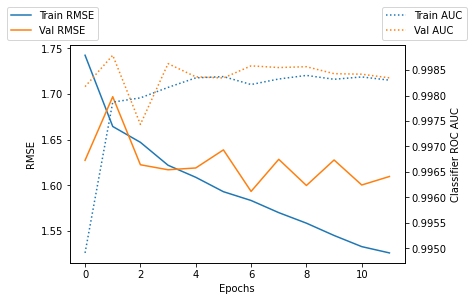

In [53]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(history.history['regression_root_mean_squared_error'] ,label='Train RMSE')
ax.plot(history.history['val_regression_root_mean_squared_error'] ,label='Val RMSE')

ax2 = ax.twinx()

ax2.plot(history.history['classifier_auc'],label='Train AUC', linestyle=':')
ax2.plot(history.history['val_classifier_auc'],label = 'Val AUC', linestyle=':')

ax.set_xlabel('Epochs')

ax.set_ylabel('RMSE')
ax2.set_ylabel('Classifier ROC AUC')
ax2.legend(bbox_to_anchor= (1.2, 1.2))
ax.legend(bbox_to_anchor= (0.1, 1.2))
#ax2.legend(loc='upper', bbox_to_anchor= (1.1, 0.6), ncol=1,
 #           borderaxespad=0, frameon=False)
#plt.legend(loc='upper right')
plt.show()

### Performance


In [54]:
metrics = complex_model.metrics_names
metrics

['loss',
 'regression_loss',
 'classifier_loss',
 'regression_root_mean_squared_error',
 'regression_mean_absolute_error',
 'classifier_auc',
 'classifier_precision',
 'classifier_recall']

In [56]:
perf = {k:[] for k in ['RMSE', 'ROC AUC', 'Recall']}
for inputs, r_targets,c_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']],
                                             [train_purchase, valid_purchase, test_purchase]):
    
    dum = complex_model.evaluate(inputs,{'regression':r_targets,'classifier':c_targets})
    perf['RMSE'].append(dum[metrics.index('regression_root_mean_squared_error')])
    perf['ROC AUC'].append(dum[metrics.index('classifier_auc')])
    perf['Recall'].append(dum[metrics.index('classifier_recall')])
    del dum
complex_nn_exp = pd.DataFrame(perf,index = ['train','validation','test'])
complex_nn_exp
    

2257/2257 [==============================] - 3s 1ms/step - loss: 2.6729 - regression_loss: 2.6333 - classifier_loss: 0.0395 - regression_root_mean_squared_error: 1.6228 - regression_mean_absolute_error: 0.2873 - classifier_auc: 0.9984 - classifier_precision: 0.9824 - classifier_recall: 0.9824


,RMSE,ROC AUC,Recall
train,1.533049,0.998760,0.984142
validation,1.593461,0.998582,0.982774
test,1.622757,0.998440,0.982436


In [58]:
base_seq_nn

,RMSE
train,1.555521
validation,1.592071
test,1.620039


In [59]:
seq_nn_w_clf

,RMSE
train,1.539805
validation,1.586827
test,1.619583


This NN is doesn't have any additoinal predictive power on the validation and test sets, and it is more over fit to the training data.   Not an improvement.

### Complex model 2
Using classifier output as input into regression

In [70]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 100
epochs = 100

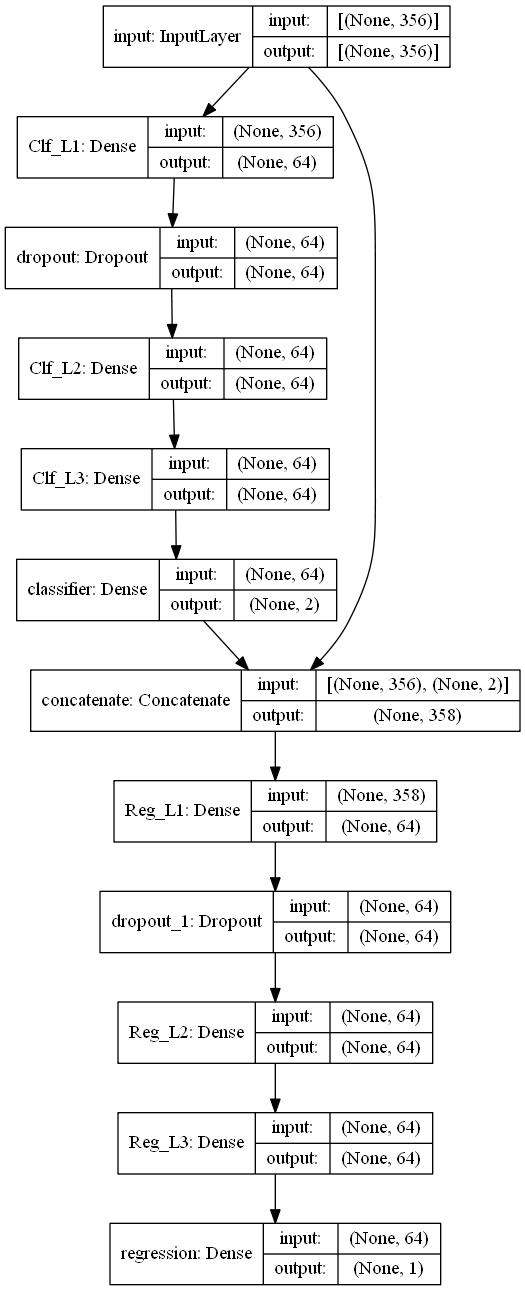

In [71]:
tf.keras.backend.clear_session()
### Create input layer
inputs = tf.keras.Input(shape=(input_size,),name='input') # shape (features,)

### Building the classifier
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L1')(inputs) # shape (None, 64)
clf = tf.keras.layers.Dropout(.2)(clf)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L2')(clf) # shape (None, 64)
clf = tf.keras.layers.Dense(hidden_layer_size, activation = 'relu', name='Clf_L3')(clf) # shape (None, 64)
clf_out = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(clf) # shape (None, 2)

### Now build regression portion of model
reg = tf.keras.layers.concatenate([inputs, clf_out],axis=1) # shape (features + 1, )

reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L1')(reg) # shape (None, 64)
reg = tf.keras.layers.Dropout(.2)(reg)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L2')(reg) # shape (None, 64)
reg = tf.keras.layers.Dense(hidden_layer_size, activation='relu', name='Reg_L3')(reg) # shape (None, 64)
reg_out = tf.keras.layers.Dense(1, name='regression')(reg) # shape (None,1)


complex_model = tf.keras.Model(inputs=inputs, outputs = [reg_out, clf_out])

tf.keras.utils.plot_model(complex_model, show_shapes=True)

#complex_model.summary()


In [72]:
complex_model.compile(optimizer='adam',
                     loss={'classifier':tf.keras.losses.BinaryCrossentropy(from_logits=False),
                          'regression': tf.keras.losses.MeanSquaredError()},
                     metrics={'classifier':[tf.keras.metrics.AUC(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.Recall()],
                             'regression': [tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.MeanAbsoluteError()]}
                     )

In [73]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = complex_model.fit(train['inputs'],
                           {'regression':train['targets'],'classifier':train_purchase},
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=earlystop,
                           validation_data=(valid['inputs'],{'regression':valid['targets'],
                                                              'classifier':valid_purchase}),
                           verbose=2
                           )

Epoch 1/100
5059/5059 - 18s - loss: 3.0473 - regression_loss: 3.0083 - classifier_loss: 0.0390 - regression_root_mean_squared_error: 1.7344 - regression_mean_absolute_error: 0.3944 - classifier_auc: 0.9970 - classifier_precision: 0.9854 - classifier_recall: 0.9854 - val_loss: 2.6387 - val_regression_loss: 2.6057 - val_classifier_loss: 0.0330 - val_regression_root_mean_squared_error: 1.6142 - val_regression_mean_absolute_error: 0.2966 - val_classifier_auc: 0.9969 - val_classifier_precision: 0.9873 - val_classifier_recall: 0.9873
Epoch 2/100
5059/5059 - 13s - loss: 2.8021 - regression_loss: 2.7679 - classifier_loss: 0.0342 - regression_root_mean_squared_error: 1.6637 - regression_mean_absolute_error: 0.3391 - classifier_auc: 0.9973 - classifier_precision: 0.9867 - classifier_recall: 0.9867 - val_loss: 2.6518 - val_regression_loss: 2.6201 - val_classifier_loss: 0.0317 - val_regression_root_mean_squared_error: 1.6187 - val_regression_mean_absolute_error: 0.2929 - val_classifier_auc: 0.9976

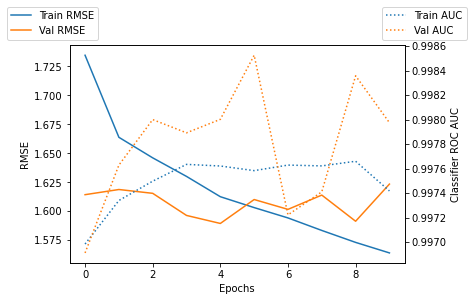

In [74]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(history.history['regression_root_mean_squared_error'] ,label='Train RMSE')
ax.plot(history.history['val_regression_root_mean_squared_error'] ,label='Val RMSE')

ax2 = ax.twinx()

ax2.plot(history.history['classifier_auc'],label='Train AUC', linestyle=':')
ax2.plot(history.history['val_classifier_auc'],label = 'Val AUC', linestyle=':')

ax.set_xlabel('Epochs')

ax.set_ylabel('RMSE')
ax2.set_ylabel('Classifier ROC AUC')
ax2.legend(bbox_to_anchor= (1.2, 1.2))
ax.legend(bbox_to_anchor= (0.1, 1.2))
#ax2.legend(loc='upper', bbox_to_anchor= (1.1, 0.6), ncol=1,
 #           borderaxespad=0, frameon=False)
#plt.legend(loc='upper right')
plt.show()

In [75]:
perf = {k:[] for k in ['RMSE', 'ROC AUC', 'Recall']}
for inputs, r_targets,c_targets in zip([train['inputs'],valid['inputs'], test['inputs']],
                                             [train['targets'],valid['targets'], test['targets']],
                                             [train_purchase, valid_purchase, test_purchase]):
    
    dum = complex_model.evaluate(inputs,{'regression':r_targets,'classifier':c_targets})
    perf['RMSE'].append(dum[metrics.index('regression_root_mean_squared_error')])
    perf['ROC AUC'].append(dum[metrics.index('classifier_auc')])
    perf['Recall'].append(dum[metrics.index('classifier_recall')])
    del dum
pd.DataFrame(perf,index = ['train','validation','test'])
    

2257/2257 [==============================] - 2s 1ms/step - loss: 2.6490 - regression_loss: 2.6180 - classifier_loss: 0.0310 - regression_root_mean_squared_error: 1.6180 - regression_mean_absolute_error: 0.3013 - classifier_auc: 0.9977 - classifier_precision: 0.9879 - classifier_recall: 0.9879


,RMSE,ROC AUC,Recall
train,1.573596,0.998021,0.988509
validation,1.589410,0.998002,0.988036
test,1.618015,0.997735,0.987922


In [76]:
base_seq_nn

,RMSE
train,1.555521
validation,1.592071
test,1.620039


In [77]:
seq_nn_w_clf

,RMSE
train,1.539805
validation,1.586827
test,1.619583


This model produced a test RMSE that is a tiny bit lower than the two sequential models, and it appears to be less overfit to the training data.  Perhaps this one could be used. 